# Generating recipe-like text from ingredients input

Sources: 
*     Andrej Karpathy. (2023). Let's build GPT: from scratch, in code, spelled out.. [Online Video]. 17 January 2023. Available from: https://www.youtube.com/watch?v=kCc8FmEb1nY. [Accessed: 26 April 2023].
*     Bień, M., Gilski, M., Maciejewska, M., Taisner, W., Wisniewski, D. and Lawrynowicz, A., 2020, December. RecipeNLG: A cooking recipes dataset for semi-structured text generation. In Proceedings of the 13th International Conference on Natural Language Generation (pp. 22-28).
*     François Chollet and Jason Liang. 2021. Text generation with GPT-2 using Keras. [online] Keras.io. Available at: https://keras.io/examples/generative/text_generation_gpt/ [Accessed 5 May 2023].

### 0. Environment Setup

In [1]:
import pandas as pd
import ast
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
!pip install keras_nlp
import keras_nlp
import os
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.2 MB/s eta 0:00:00


The data we have used for this project is the RecipeNLP dataset (Bień et al., (2020)).

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset = pd.read_csv("/content/drive/MyDrive/XXXXX/01_Code/full_dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!nvidia-smi

Thu May  4 18:16:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1. Data Preparation

In [3]:
dataset.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [5]:
# Process recipe data

def format_row(row):
    '''
    Function to format recipe data into a consistent
    structure for tokenisation.
    '''
    title = row['title']
    ingredients = ast.literal_eval(row['NER'])
    ingredients = ', '.join(ingredients)
    ingredients = f" {ingredients} "
    directions_list = ast.literal_eval(row['directions'])
    directions = ' '.join(directions_list)
    
    # 1 recipe per line
    return f"{title}.{ingredients}.{directions}\n" 

'No-Bake Nut Cookies. brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits .In '

In [ ]:
# Generate formatted recipe data

long_text = ''.join(dataset.apply(format_row, axis=1))

In [7]:
# Save formatted recipe data to text file

text_file = open("/content/dataset_full.txt", "w")
text_file.write(long_text)
text_file.close()

In [8]:
# Free up memory

del long_text

In [9]:
# Load processed recipe data

with open('/content/dataset_full.txt') as f:
    lines = f.readlines()

lines[0:2]

['No-Bake Nut Cookies. brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits .In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes.\n',
 "Jewell Ball'S Chicken. beef, chicken breasts, cream of mushroom soup, sour cream .Place chipped beef on bottom of baking dish. Place chicken on top of beef. Mix soup and cream together; pour over chicken. Bake, uncovered, at 275° for 3 hours.\n"]

In [10]:
# Check dataset size

len(lines)

2261839

In [12]:
!nvidia-smi

Thu May  4 18:18:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
# Create training and validation data

with open('/content/dataset_train.txt', 'w') as train_file, \
     open('/content/dataset_val.txt', 'w') as val_file:
    
    split_index = round(len(lines) * 0.9)
    
    train_text = ''.join(lines[:split_index])
    val_text = ''.join(lines[split_index:])
    
    train_file.write(train_text)
    val_file.write(val_text)

In [12]:
# Free up memory

del train_text
del val_text

In [13]:
# Set hyperparameters

BATCH_SIZE = 64
BLOCK_SIZE = 128

In [14]:
# Create batches for training and validation

train_set = (
    tf.data.TextLineDataset("/content/dataset_train.txt")
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

val_set = (
    tf.data.TextLineDataset("/content/dataset_val.txt")
    .batch(BATCH_SIZE)
)

### 2. Build Model Architecture

In [30]:
# Model hyperparameters
EMBED_DIM = 256
FF_DIM = 256
NUM_HEADS = 5 #3
NUM_LAYERS = 2
VOCAB_SIZE = 5000 

# Training hyperparameters
EPOCHS = 6
LEARNING_RATE = 1e-3

# Inference hyperparameters
NUM_INFERENCE_TOKENS = 80

In [31]:
# Train tokenizer vocabulary

vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_set,
    vocabulary_size = VOCAB_SIZE,
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

In [33]:
# Load tokenizer

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=BLOCK_SIZE,
    lowercase=True,
)

In [34]:
# Function to tokenize data

start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=BLOCK_SIZE,
    start_value=tokenizer.token_to_id("[BOS]"),
)

def preprocess(inputs):
    '''
    Function to tokenize data. 
    '''
    outputs=tokenizer(inputs)
    features=start_packer(outputs)
    labels=outputs
    return features, labels

In [ ]:
# Tokenize and split into train and label sequences

train_set_tokenised = train_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
val_set_tokenised = val_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

In [35]:
# Build necessary layers

# Input layer
inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)

# Embedding
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=BLOCK_SIZE,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)

# Decoder layers
for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim= FF_DIM,
    )
    x = decoder_layer(x) 

# Output FFN layer
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Algorithm hyperparameters
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)

In [36]:
# Compile model

opt = tf.keras.optimizers.Adam(LEARNING_RATE) # custom learning rate schedule from seminar?
model.compile(optimizer=opt, loss=loss_fn, metrics=[perplexity])

In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        1312768   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_decoder_4 (Tran  (None, None, 256)        394749    
 sformerDecoder)                                                 
                                                                 
 transformer_decoder_5 (Tran  (None, None, 256)        394749    
 sformerDecoder)                                                 
                                                                 
 dense_1 (Dense)             (None, None, 5000)        1285

### 3. Train model

In [38]:
history = model.fit(train_set_tokenised, validation_data=val_set_tokenised, verbose=2, epochs=EPOCHS)

Epoch 1/6
31808/31808 - 661s - loss: 2.2697 - perplexity: 9.7668 - val_loss: 2.3443 - val_perplexity: 10.4648 - 661s/epoch - 21ms/step
Epoch 2/6
31808/31808 - 575s - loss: 2.1023 - perplexity: 8.2513 - val_loss: 2.2858 - val_perplexity: 9.8821 - 575s/epoch - 18ms/step
Epoch 3/6
31808/31808 - 573s - loss: 2.0693 - perplexity: 7.9826 - val_loss: 2.2641 - val_perplexity: 9.6619 - 573s/epoch - 18ms/step
Epoch 4/6
31808/31808 - 568s - loss: 2.0528 - perplexity: 7.8513 - val_loss: 2.2525 - val_perplexity: 9.5581 - 568s/epoch - 18ms/step
Epoch 5/6
31808/31808 - 567s - loss: 2.0423 - perplexity: 7.7685 - val_loss: 2.2424 - val_perplexity: 9.4595 - 567s/epoch - 18ms/step
Epoch 6/6
31808/31808 - 568s - loss: 2.0314 - perplexity: 7.6837 - val_loss: 2.2273 - val_perplexity: 9.3153 - 568s/epoch - 18ms/step


In [ ]:
# Data for plots

loss = history.history['loss']
val_loss = history.history['val_loss']
perplexity = history.history['perplexity'] 
val_perplexity = history.history['val_perplexity'] 
epochs = range(1, len(loss) + 1)

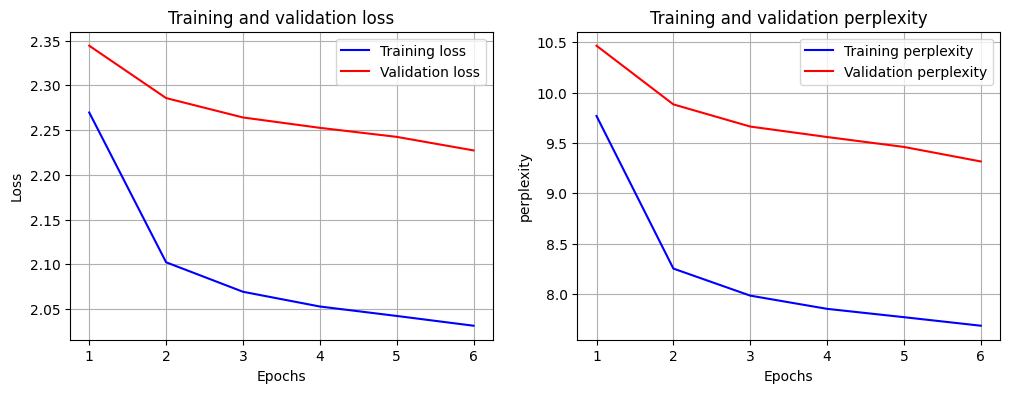

In [39]:
plt.rcParams["figure.figsize"] = [12,4]

# Plotting training and validation loss
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting training and validation metric
plt.subplot(1,2,2)
plt.plot(epochs, perplexity, 'b', label='Training perplexity')
plt.plot(epochs, val_perplexity, 'r', label='Validation perplexity')
plt.title('Training and validation perplexity')
plt.xlabel('Epochs')
plt.ylabel('perplexity')
plt.legend()
plt.grid()

plt.show()

### 4. Inference

In [40]:
# Create formatted list of ingredients for prompt

prompt_tokens = tf.convert_to_tensor([tokenizer.token_to_id("[BOS]"), 
                                      tokenizer.token_to_id("onion"), 
                                      tokenizer.token_to_id(","),
                                      tokenizer.token_to_id("garlic"),
                                      tokenizer.token_to_id(","),
                                      tokenizer.token_to_id("flour"),
                                      tokenizer.token_to_id(","),
                                      tokenizer.token_to_id("tomatoes"),
                                      tokenizer.token_to_id(","),
                                      tokenizer.token_to_id("eggs"),
                                      tokenizer.token_to_id(".")])

In [41]:
prompt_tokens

<tf.Tensor: shape=(11,), dtype=int32, numpy=array([  2, 579,  14, 585,  14, 571,  14, 641,  14, 589,  16], dtype=int32)>

In [42]:
# Return next token logits

def token_logits_fn(inputs):
    '''
    Function to return next token logits.
    '''
    cur_len = inputs.shape[1]
    output = model(inputs)
    return output[:, cur_len - 1, :]

In [43]:
# Top p search text generation

output_tokens = keras_nlp.utils.top_p_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_INFERENCE_TOKENS, 
    p=0.5,
    from_logits=True,
)

txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
b'[BOS] onion , garlic , flour , tomatoes , eggs . mix all ingredients together and pour into a greased baking dish . bake at 350 degrees for 30 minutes . [PAD] . [PAD] . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'



In [44]:
# Top k search text generation

output_tokens = keras_nlp.utils.top_k_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_INFERENCE_TOKENS,
    k=10,
    from_logits=True,
)

txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

Top-K search generated text: 
b'[BOS] onion , garlic , flour , tomatoes , eggs . preheat oven to 400 degrees f . cut the tomatoes in half , remove the stems and seeds . in the skillet , heat oil until shimmering . add the garlic and cook until fragrant , about 2 minutes . add the chopped tomatoes , then salt and pepper , and cook on top until they are wilted ( about 2 - 3 minutes ) . stir in 1'

